In [4]:
# ------------------------------
# 1. Standard Library Imports
# ------------------------------
import math
import os
import random
import timeit
import itertools
from pathlib import Path
import tempfile
import zipfile
import json
import gzip
import shutil

# ------------------------------
# 2. Data Science Libraries
# ------------------------------
import numpy as np
import pandas as pd
from numpy import linalg as LA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    Callback, 
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau
)
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# 3. Visualization Libraries
# ------------------------------
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.axes as axes
import seaborn as sns
import cv2  # OpenCV for image processing

# ------------------------------
# 4. TensorFlow Model Optimization
# ------------------------------
# Ensure that tensorflow-model-optimization is installed before importing
try:
    import tensorflow_model_optimization as tfmot
    from tensorflow_model_optimization.sparsity import keras as sparsity
except ImportError:
    print("tensorflow-model-optimization is not installed. Please install it using `pip install tensorflow-model-optimization`.")

# ------------------------------
# 5. IPython and Jupyter Extensions
# ------------------------------
from IPython.core.pylabtools import figsize
import tensorboard

# ------------------------------
# 6. Configuration and Settings
# ------------------------------
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
sns.set_context('notebook')
pd.set_option('display.max_rows', 30)
np.random.seed(1337)

# ------------------------------
# 7. Warning
# ------------------------------
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings('ignore', '.*Model failed to serialize as JSON.*')

# Jupyter-specific configurations
%config InlineBackend.figure_format = 'retina'
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
def seed_everything(seed=42):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy's random number generator
    np.random.seed(seed)
    
    # Set the seed for TensorFlow's random number generator
    tf.random.set_seed(seed)
    
    # Set the PYTHONHASHSEED environment variable to ensure reproducibility
    # os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Configure TensorFlow to use a single thread for operations
    # tf.config.threading.set_intra_op_parallelism_threads(1)
    # tf.config.threading.set_inter_op_parallelism_threads(1)
    
    # Enable deterministic operations in TensorFlow
    # os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Call the function to set all seeds
seed_everything()

In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
import zipfile

# Unzip Training.zip and Testing.zip
zip_path = 'raw-img.zip'

# Directories to extract the zip files
zip_dir = 'raw-img'

# Unzip Training.zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(zip_dir)

### Load and transform data

In [7]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Walk through each directory
dataset = 'raw-img'
walk_through_dir(dataset)

There are 10 directories and 0 images in 'raw-img'.
There are 0 directories and 2112 images in 'raw-img\butterfly'.
There are 0 directories and 1668 images in 'raw-img\cat'.
There are 0 directories and 3098 images in 'raw-img\chicken'.
There are 0 directories and 1866 images in 'raw-img\cow'.
There are 0 directories and 4863 images in 'raw-img\dog'.
There are 0 directories and 1446 images in 'raw-img\elefant'.
There are 0 directories and 2623 images in 'raw-img\horse'.
There are 0 directories and 1820 images in 'raw-img\sheep'.
There are 0 directories and 4821 images in 'raw-img\spider'.
There are 0 directories and 1862 images in 'raw-img\squirrel'.


In [ ]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

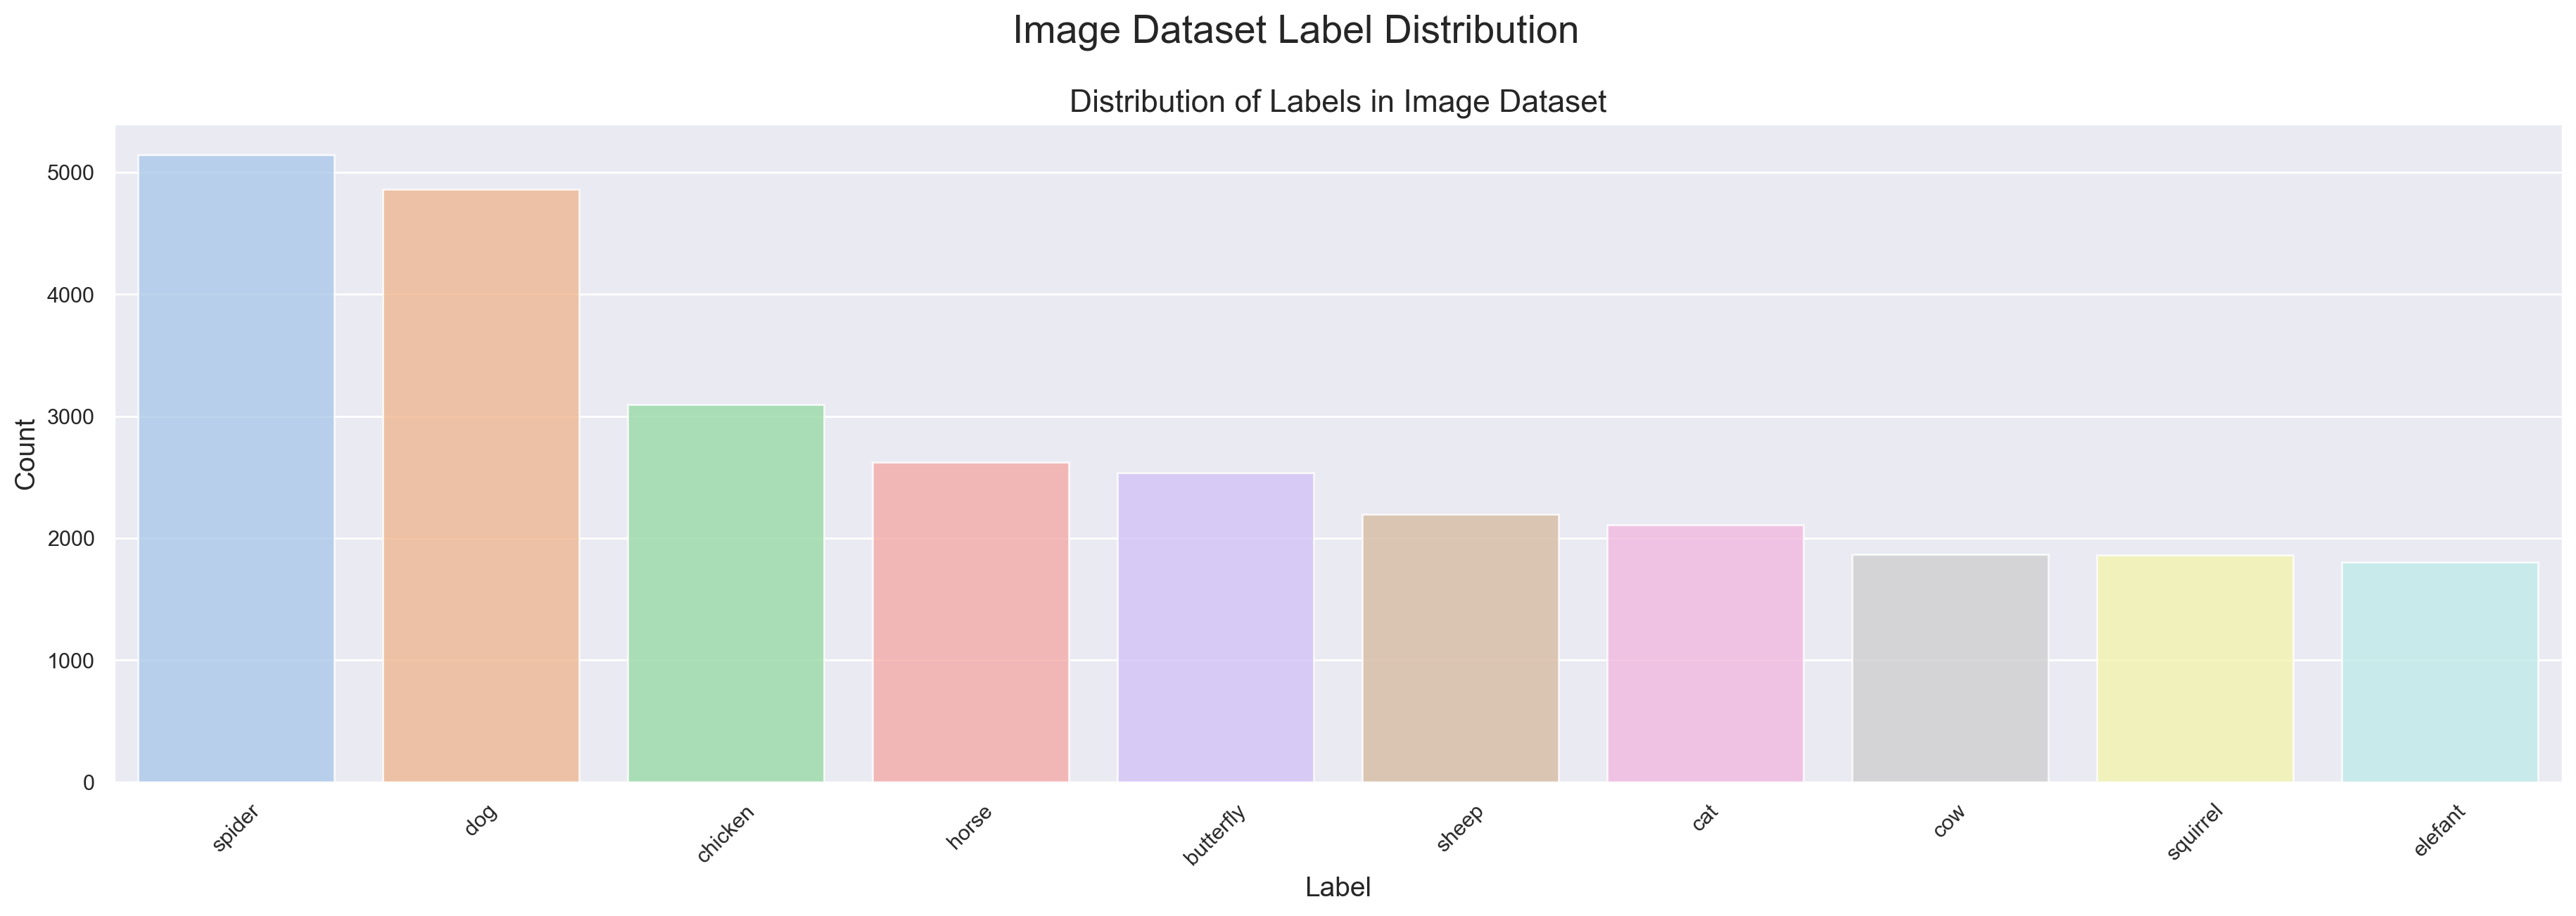

In [8]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

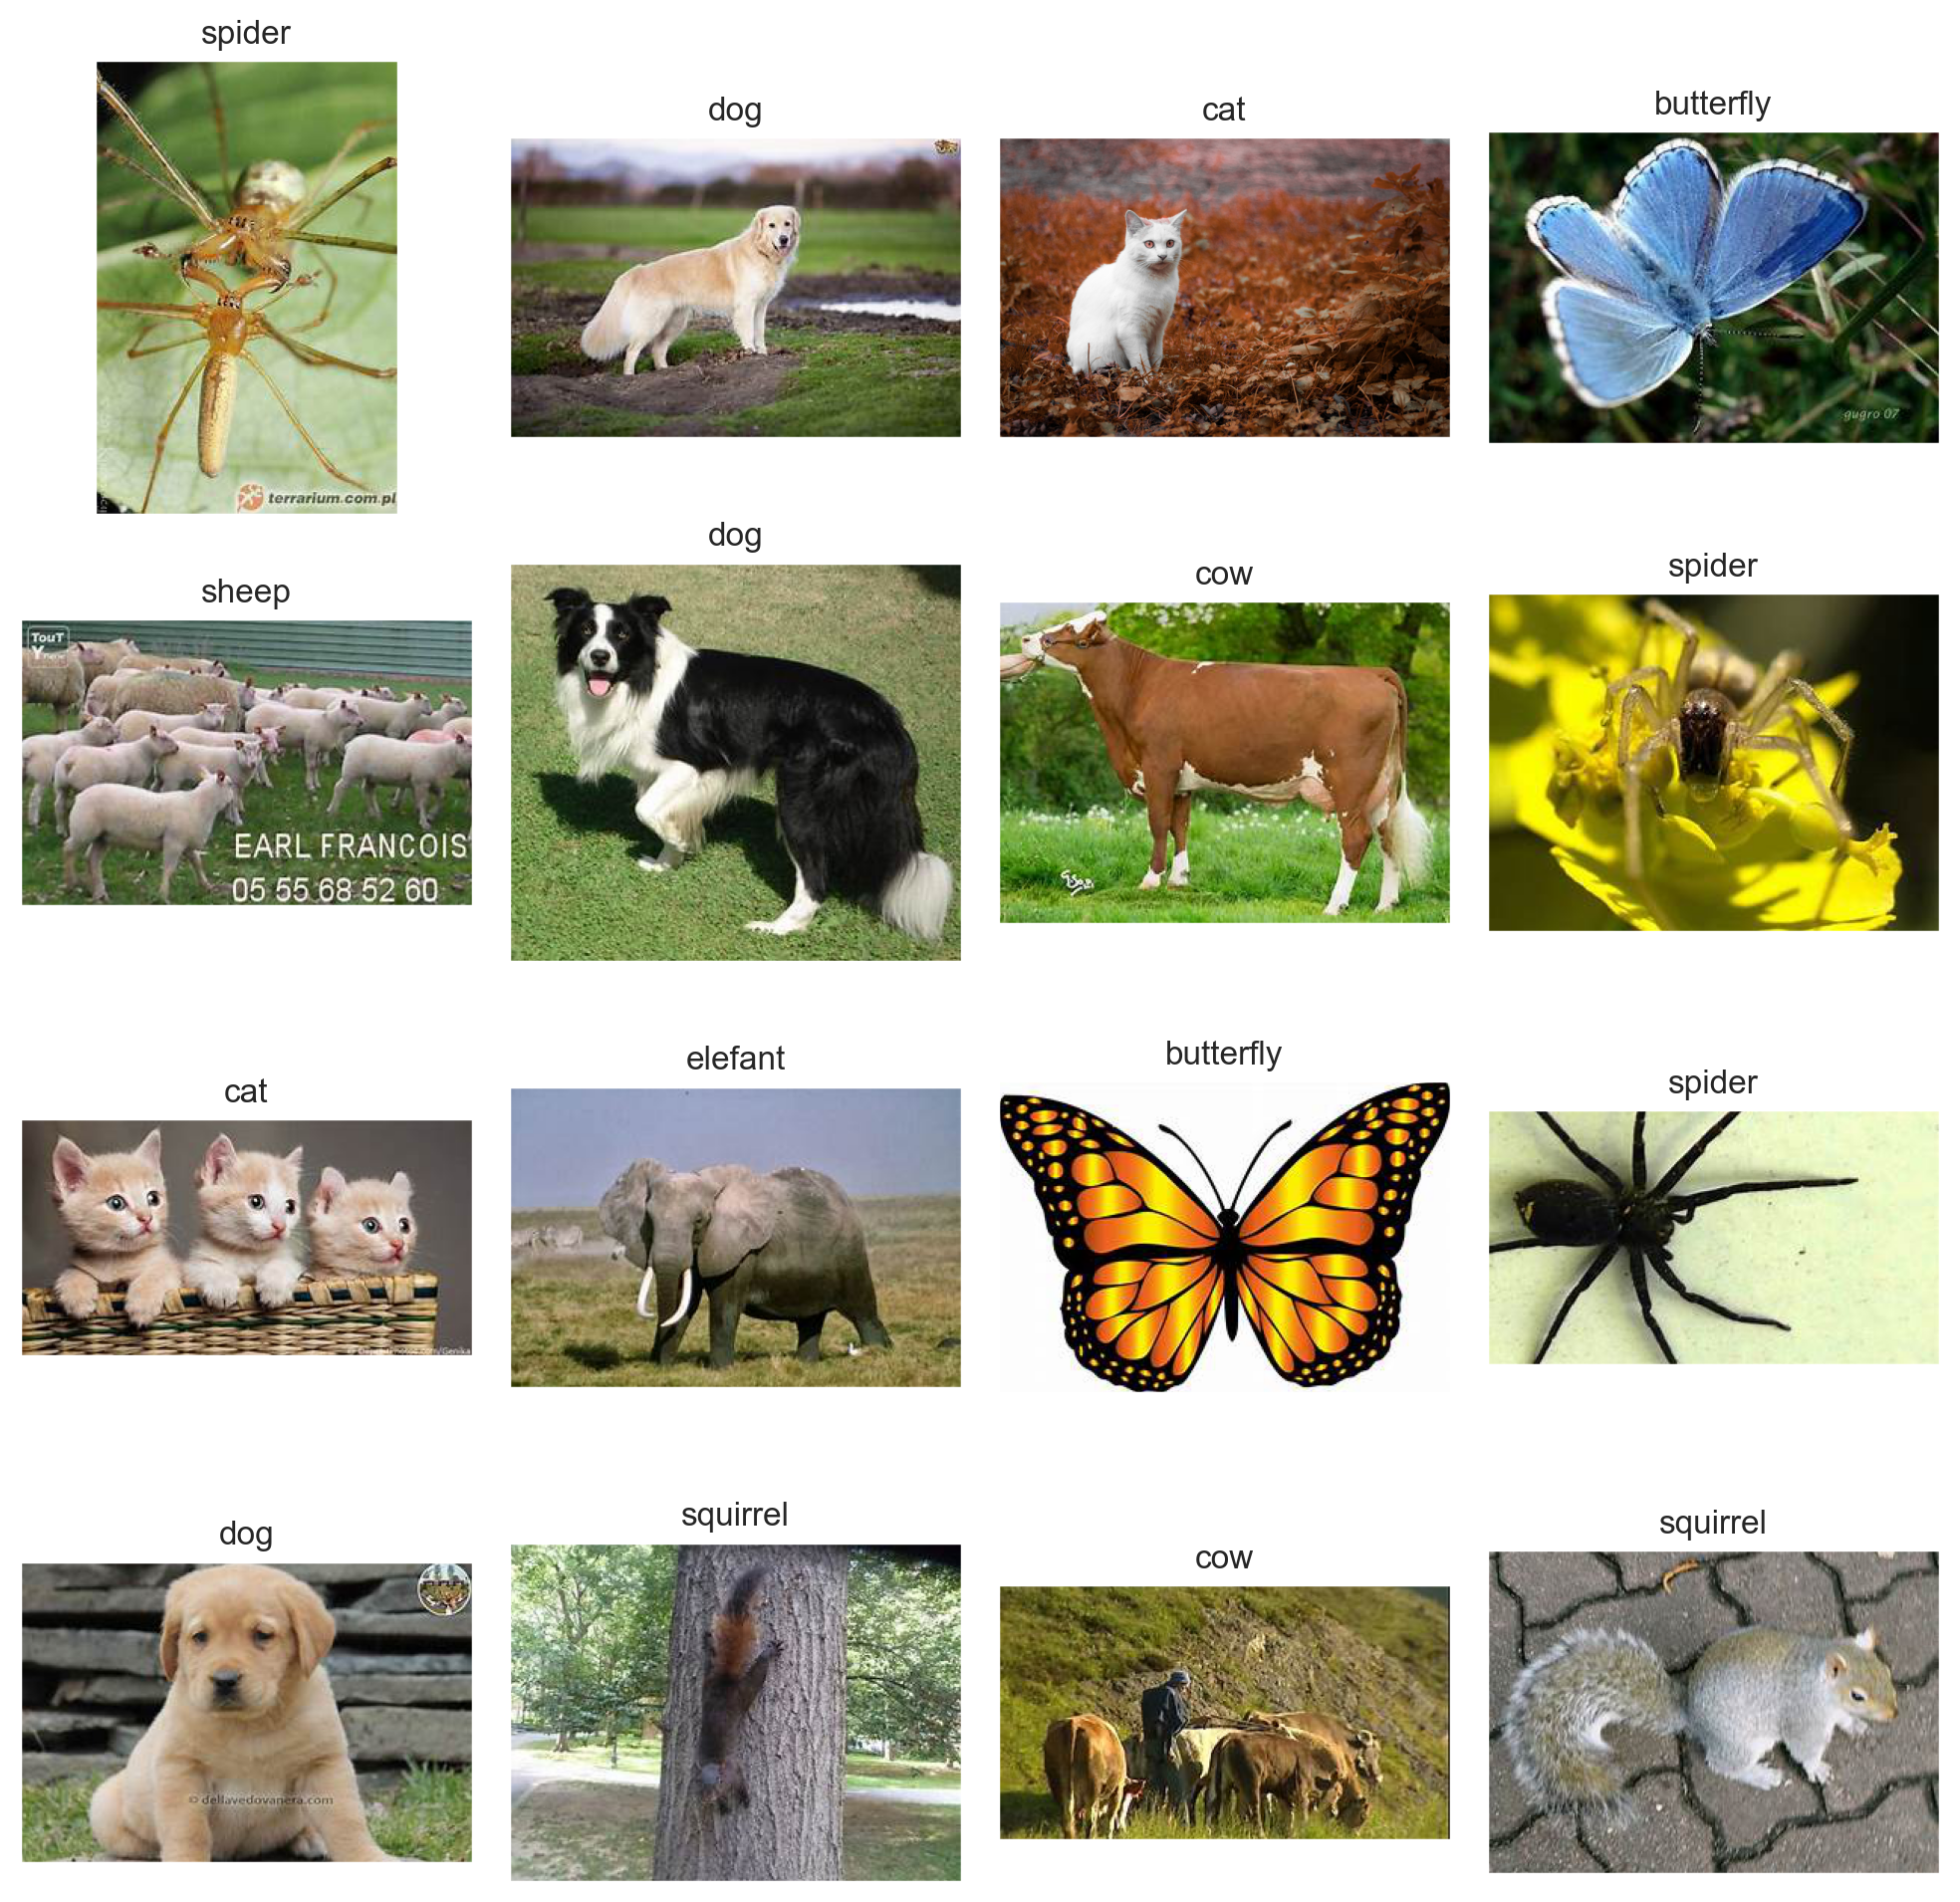

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

### Preprocessing

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 17983 validated image filenames belonging to 10 classes.
Found 4495 validated image filenames belonging to 10 classes.
Found 5620 validated image filenames belonging to 10 classes.


In [8]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [10]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

outputs = Dense(10, activation='softmax')(x)

original_model = Model(inputs=inputs, outputs=outputs)

original_model.load_weights("animals_classification_model_checkpoint.weights.h5")

original_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save the model in a standard format first
# original_model_filename = 'original_model.h5'
# original_model.save(original_model_filename)
original_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

### Weight pruning

In [13]:
# Apply weight pruning to the model
def build_weight_pruned_model(pretrained_model, augment, num_classes, pruning_params):
    # Define the pruning layer with pruning parameters
    pruning_layer = tfmot.sparsity.keras.prune_low_magnitude

    inputs = pretrained_model.input
    x = augment(inputs)

    # Pre-trained base
    x = pretrained_model.output

    # Pruned Dense layer 1
    x = pruning_layer(Dense(128, activation='relu', name='pruned_dense_1'), **pruning_params)(x)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Dropout(0.45, name='dropout_1')(x)

    # Pruned Dense layer 2
    x = pruning_layer(Dense(256, activation='relu', name='pruned_dense_2'), **pruning_params)(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(0.45, name='dropout_2')(x)

    # Output layer without pruning
    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    # Create the pruned model
    pruned_model = Model(inputs=inputs, outputs=outputs)
    return pruned_model

# Utility function to count non-zero weights
def count_nonzero_weights(model):
    nonzero = 0
    total = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
            weights = layer.get_weights()
            if weights:
                nonzero += np.count_nonzero(weights[0])
                total += weights[0].size
    return nonzero, total

# Utility function to get file size in megabytes
def get_file_size_mb(file_path):
    if os.path.exists(file_path):
        size_bytes = os.path.getsize(file_path)
        size_mb = size_bytes / (1024 * 1024)
        return size_mb
    else:
        return None

# Number of classes
num_classes = 10

# Number of Epochs
epochs = 30  # Adjust as needed

# Calculate end_step for pruning schedule
end_step = np.ceil(17983 / BATCH_SIZE).astype(np.int32) * epochs

# Sparsity levels to test
sparsity_levels = [0.3, 0.5, 0.7, 0.9]

# Dictionaries to hold data for plotting and evaluation
training_accuracy = {}
validation_accuracy = {}
test_results = {}

# List to store data for the comparison table
table_data = []

In [15]:
for final_sparsity in sparsity_levels:
    print(f"Pruning with final sparsity: {final_sparsity}")

    # Define pruning parameters with the current final_sparsity
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=final_sparsity,
            begin_step=0,
            end_step=end_step
        )
    }

    # Build the pruned model
    weight_pruned_model = build_weight_pruned_model(pretrained_model, augment, num_classes, pruning_params)

    # Load initial weights into the model
    weight_pruned_model.load_weights("animals_classification_model_checkpoint.weights.h5", by_name=True)

    # Compile the pruned model
    weight_pruned_model.compile(
        optimizer=Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks for pruning
    pruning_callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir=f'pruning_logs_{int(final_sparsity*100)}'),
        ModelCheckpoint(
            f'animals_classification_weight_pruned_model_checkpoint_sparsity_{int(final_sparsity*100)}.weights.h5',
            save_weights_only=True,
            monitor='val_accuracy',
            save_best_only=True
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train the pruned model
    history = weight_pruned_model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=epochs,
        callbacks=pruning_callbacks
    )

    # Strip pruning wrappers
    wp_model = tfmot.sparsity.keras.strip_pruning(weight_pruned_model)

    # Save the pruned model
    model_filename = f'weight_pruned_animals_classification_model_sparsity_{int(final_sparsity*100)}.h5'
    wp_model.save(model_filename)
    print(f"Pruned model with {int(final_sparsity*100)}% sparsity saved as '{model_filename}'")

    # Save the training history
    history_filename = f'weight_pruning_training_history_sparsity_{int(final_sparsity*100)}.json'
    history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}
    with open(history_filename, 'w') as f:
        json.dump(history_dict, f)

Pruning with final sparsity: 0.3


D:\anaconda\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/30
562/562 [==============================] - 686s 1s/step - loss: 2.6304 - accuracy: 0.2507 - val_loss: 1.0902 - val_accuracy: 0.6879
Epoch 2/30
562/562 [==============================] - 603s 1s/step - loss: 1.5093 - accuracy: 0.5307 - val_loss: 0.6165 - val_accuracy: 0.8456
Epoch 3/30
562/562 [==============================] - 493s 877ms/step - loss: 1.0390 - accuracy: 0.6768 - val_loss: 0.4141 - val_accuracy: 0.9028
Epoch 4/30
562/562 [==============================] - 574s 1s/step - loss: 0.8098 - accuracy: 0.7541 - val_loss: 0.3210 - val_accuracy: 0.9221
Epoch 5/30
562/562 [==============================] - 506s 900ms/step - loss: 0.6434 - accuracy: 0.8079 - val_loss: 0.2612 - val_accuracy: 0.9324
Epoch 6/30
562/562 [==============================] - 490s 871ms/step - loss: 0.5543 - accuracy: 0.8376 - val_loss: 0.2217 - val_accuracy: 0.9419
Epoch 7/30
562/562 [==============================] - 488s 869ms/step - loss: 0.4709 - accuracy: 0.8637 - val_loss: 0.1964 - val_accu

#### Find best sparsity by comparing pruned models with original model

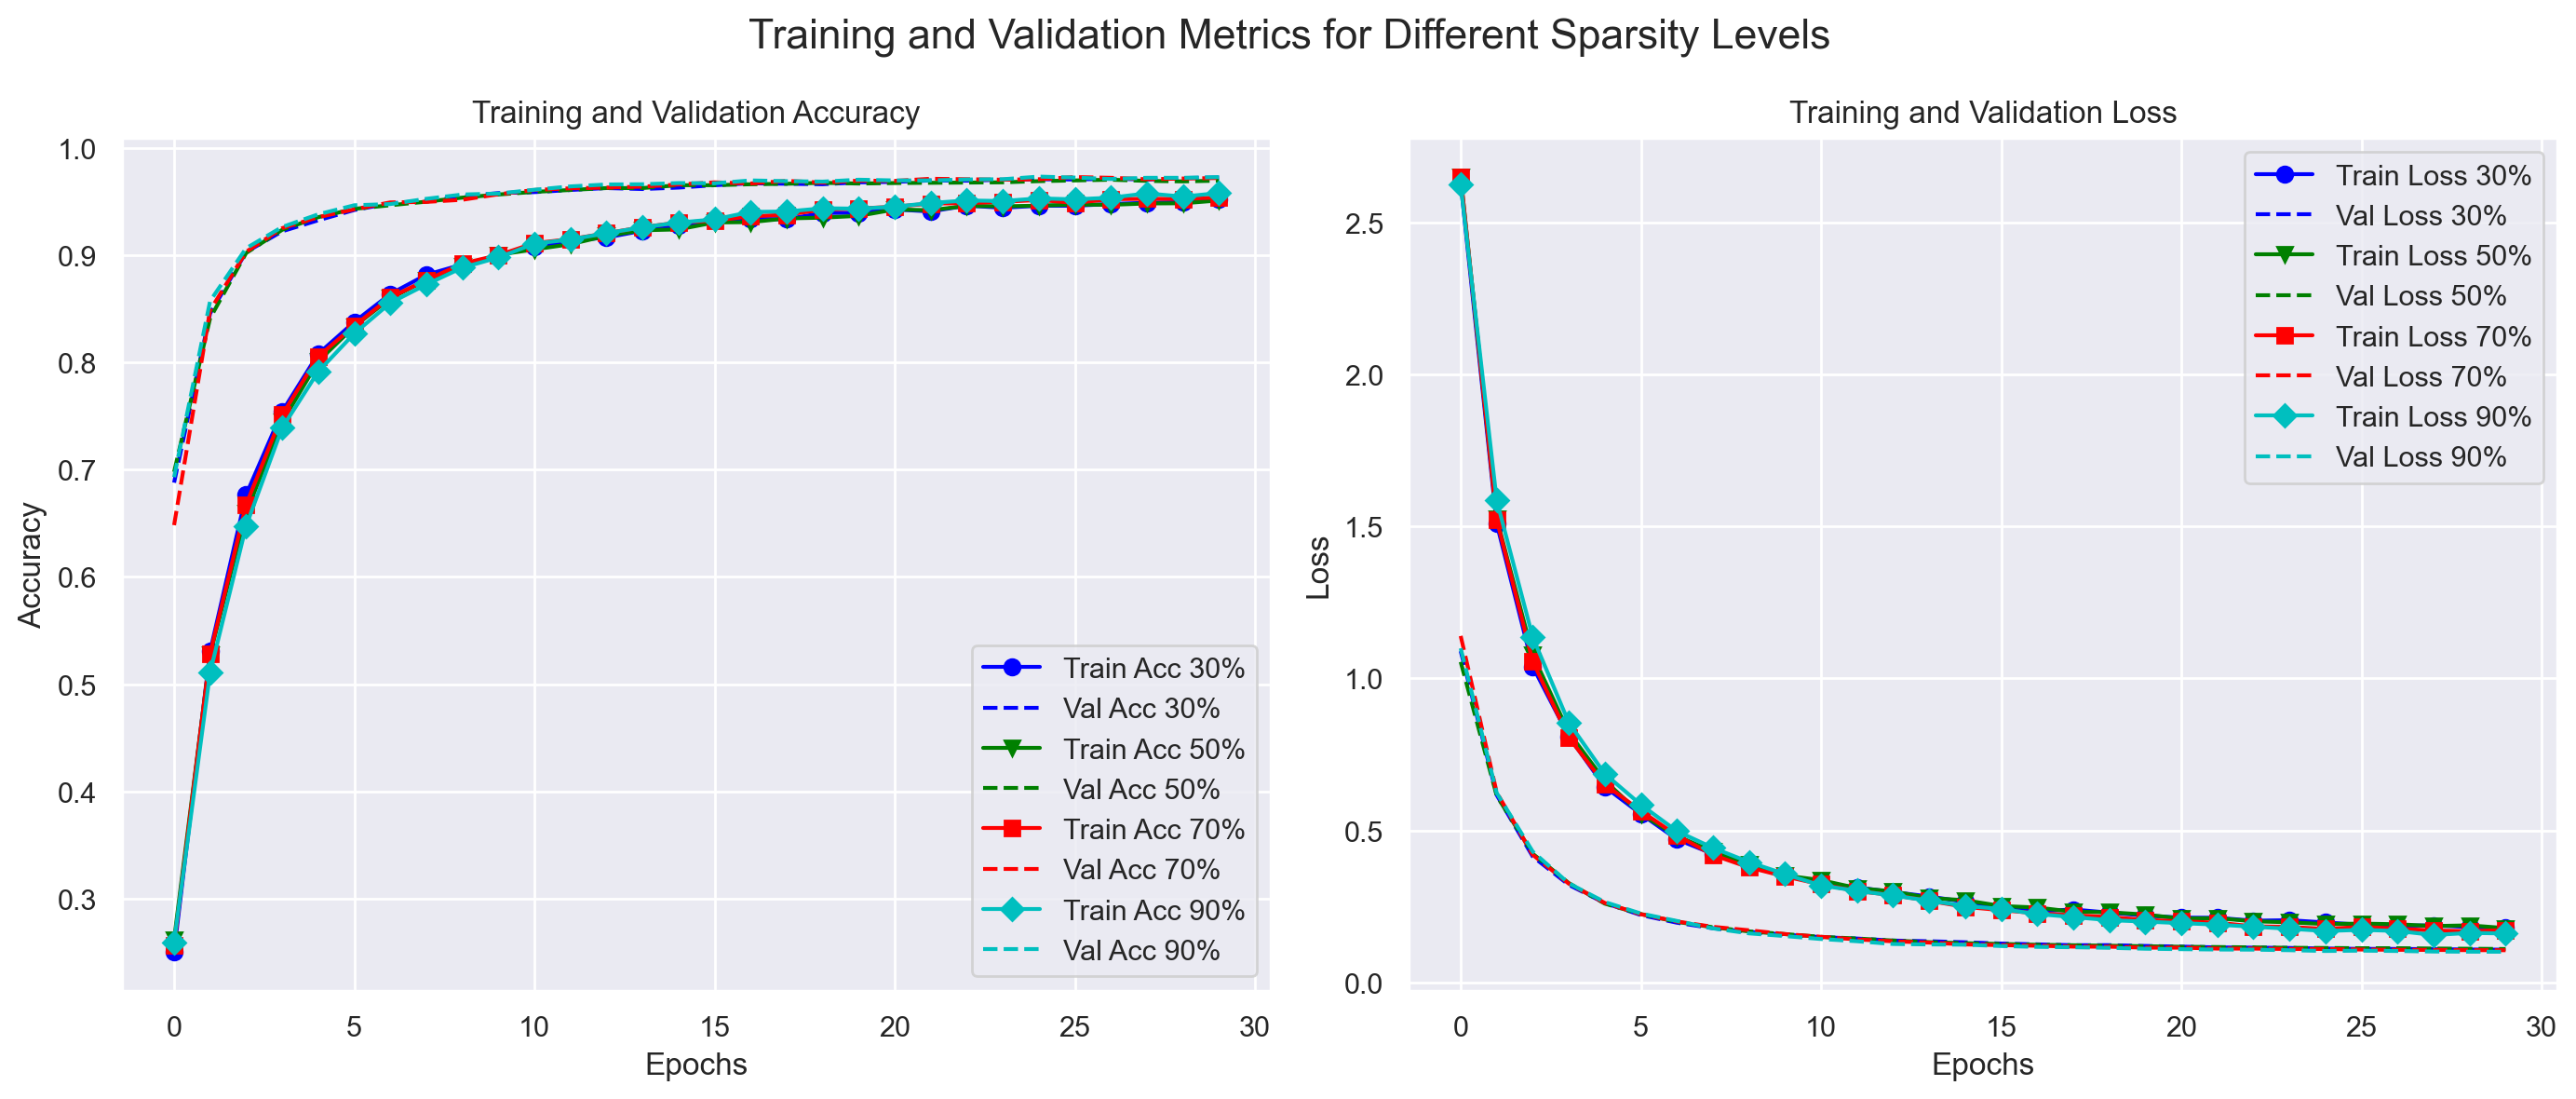


Final Training and Validation Accuracies:
Model with 30% sparsity:
  Final Training Accuracy: 95.18%
Final Validation Accuracy: 97.22%

Model with 50% sparsity:
  Final Training Accuracy: 95.08%
Final Validation Accuracy: 96.93%

Model with 70% sparsity:
  Final Training Accuracy: 95.37%
Final Validation Accuracy: 97.17%

Model with 90% sparsity:
  Final Training Accuracy: 95.78%
Final Validation Accuracy: 97.26%



In [16]:
sparsity_percentages = [int(s * 100) for s in sparsity_levels]

# Dictionaries to store accuracies and losses
training_accuracies = {}
validation_accuracies = {}
training_losses = {}
validation_losses = {}

# For storing final accuracies
final_training_accuracies = {}
final_validation_accuracies = {}

# For plotting
epochs = None

for sparsity in sparsity_levels:
    sparsity_percentage = int(sparsity * 100)
    history_filename = f'weight_pruning_training_history_sparsity_{sparsity_percentage}.json'
    
    # Load the training history
    with open(history_filename, 'r') as f:
        history = json.load(f)
    
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    if epochs is None:
        epochs = range(len(accuracy))
    
    # Store the metrics
    training_accuracies[sparsity_percentage] = accuracy
    validation_accuracies[sparsity_percentage] = val_accuracy
    training_losses[sparsity_percentage] = loss
    validation_losses[sparsity_percentage] = val_loss
    
    # Store final accuracies
    final_training_accuracies[sparsity_percentage] = accuracy[-1]
    final_validation_accuracies[sparsity_percentage] = val_accuracy[-1]

# Plotting the accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Colors and markers for different sparsity levels
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['o', 'v', 's', 'D', '^']

# Plot Training and Validation Accuracy
for idx, sparsity_percentage in enumerate(sparsity_percentages):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    acc = training_accuracies[sparsity_percentage]
    val_acc = validation_accuracies[sparsity_percentage]
    
    ax1.plot(epochs, acc, color=color, label=f'Train Acc {sparsity_percentage}%', marker=marker)
    ax1.plot(epochs, val_acc, color=color, linestyle='--', label=f'Val Acc {sparsity_percentage}%')

ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Training and Validation Loss
for idx, sparsity_percentage in enumerate(sparsity_percentages):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    loss = training_losses[sparsity_percentage]
    val_loss = validation_losses[sparsity_percentage]
    
    ax2.plot(epochs, loss, color=color, label=f'Train Loss {sparsity_percentage}%', marker=marker)
    ax2.plot(epochs, val_loss, color=color, linestyle='--', label=f'Val Loss {sparsity_percentage}%')

ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

fig.suptitle('Training and Validation Metrics for Different Sparsity Levels', fontsize=16)
plt.tight_layout()
plt.show()

# Outputting each model's final training and validation accuracy
print("\nFinal Training and Validation Accuracies:")
for sparsity_percentage in sparsity_percentages:
    final_train_acc = final_training_accuracies[sparsity_percentage]
    final_val_acc = final_validation_accuracies[sparsity_percentage]
    print(f"Model with {sparsity_percentage}% sparsity:")
    print(f"  Final Training Accuracy: {final_train_acc * 100:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%\n")

In [ ]:
# Compute original model sparsity
original_nonzero, original_total = count_nonzero_weights(original_model)
original_sparsity = (1 - original_nonzero / original_total) * 100  # Sparsity in percentage

# Compress the original model using gzip
compressed_original_model_filename = 'original_model.gz'
with open(original_model_filename, 'rb') as f_in, gzip.open(compressed_original_model_filename, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
print(f"Compressed original model saved as '{compressed_original_model_filename}'")
# Get the compressed model size
original_size = get_file_size_mb(compressed_original_model_filename)

print(f"Original Model Sparsity: {original_sparsity:.2f}%")
print(f"Compressed Original Model Size: {original_size:.2f} MB")

# Store original model data
table_data.append({
    'Sparsity Level (%)': 0,  # Original model has 0% additional sparsity
    'Model Sparsity (%)': original_sparsity,
    'Compressed Model Size (MB)': original_size,
    #'TFLite Model Size (MB)': original_size,
    'Size Reduction (MB)': 0.0,
    'Size Reduction (%)': 0.0
})

Compressed original model saved as 'original_model.gz'
Original Model Sparsity: 0.00%
Compressed Original Model Size: 226.26 MB


In [ ]:
# Process each pruned model
for sparsity in sparsity_levels:
    sparsity_percentage = int(sparsity * 100)
    print(f"\nProcessing model with {sparsity_percentage}% sparsity level...")

    # Load the pruned model
    model_filename = f'weight_pruned_animals_classification_model_sparsity_{sparsity_percentage}.h5'
    pruned_model = tf.keras.models.load_model(model_filename)

    # Strip pruning wrappers
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

    # Compute sparsity
    pruned_nonzero, pruned_total = count_nonzero_weights(stripped_pruned_model)
    pruned_sparsity = (1 - pruned_nonzero / pruned_total) * 100  # Sparsity in percentage

    print(f"Model Sparsity after stripping: {pruned_sparsity:.2f}%")

    # Compress the model using gzip
    compressed_model_filename = model_filename + '.gz'
    with open(model_filename, 'rb') as f_in, gzip.open(compressed_model_filename, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"Compressed model saved as '{compressed_model_filename}'")

    # Get the compressed model size
    pruned_size = get_file_size_mb(compressed_model_filename)

    # Calculate size reduction
    size_diff = original_size - pruned_size
    if original_size > 0:
        percent_reduction = (size_diff / original_size) * 100
    else:
        percent_reduction = 0

    # print(f"Weight-Pruned TFLite Model Size: {pruned_size:.2f} MB")
    print(f"Weight-Pruned Compressed Model Size: {pruned_size:.2f} MB")
    print(f"Size Reduction after Pruning: {size_diff:.2f} MB ({percent_reduction:.2f}%)")

    # Store data for the table
    table_data.append({
        'Sparsity Level (%)': sparsity_percentage,
        'Model Sparsity (%)': pruned_sparsity,
        'Compressed Model Size (MB)': pruned_size,
        # 'TFLite Model Size (MB)': pruned_size,
        'Size Reduction (MB)': size_diff,
        'Size Reduction (%)': percent_reduction
    })

# Create and display the comparison table
df = pd.DataFrame(table_data)

print("\nComparison of Models at Different Sparsity Levels:")
print(df.to_string(index=False))


Processing model with 30% sparsity level...
Model Sparsity after stripping: 0.17%
Compressed model saved as 'weight_pruned_animals_classification_model_sparsity_30.h5.gz'
Weight-Pruned Compressed Model Size: 225.97 MB
Size Reduction after Pruning: 0.29 MB (0.13%)

Processing model with 50% sparsity level...
Model Sparsity after stripping: 0.28%
Compressed model saved as 'weight_pruned_animals_classification_model_sparsity_50.h5.gz'
Weight-Pruned Compressed Model Size: 225.74 MB
Size Reduction after Pruning: 0.52 MB (0.23%)

Processing model with 70% sparsity level...
Model Sparsity after stripping: 0.40%
Compressed model saved as 'weight_pruned_animals_classification_model_sparsity_70.h5.gz'
Weight-Pruned Compressed Model Size: 225.48 MB
Size Reduction after Pruning: 0.77 MB (0.34%)

Processing model with 90% sparsity level...
Model Sparsity after stripping: 0.51%
Compressed model saved as 'weight_pruned_animals_classification_model_sparsity_90.h5.gz'
Weight-Pruned Compressed Model Si

#### Evaluate the best weight pruned model on the test set

In [28]:
# Find the sparsity_percentage with highest validation accuracy
best_sparsity_percentage = 90
best_accuracy = final_validation_accuracies[best_sparsity_percentage]
print(f"Best sparsity percentage is {best_sparsity_percentage}% with validation accuracy {best_accuracy * 100:.2f}%")

# Load the best pruned model
model_filename = f'weight_pruned_animals_classification_model_sparsity_{best_sparsity_percentage}.h5'
best_pruned_model = tf.keras.models.load_model(model_filename)

Best sparsity percentage is 90% with validation accuracy 97.26%


In [31]:
def get_compressed_model_filename(best_sparsity_percentage):
    """Generate the compressed model filename based on sparsity level."""
    return f'weight_pruned_animals_classification_model_sparsity_{int(best_sparsity_percentage)}.h5.gz'

def decompress_gzip_model(compressed_model_path, decompressed_model_path):
    """
    Decompress a .h5.gz file to a .h5 file.

    Parameters:
    - compressed_model_path: Path to the .h5.gz compressed model
    - decompressed_model_path: Path where the decompressed .h5 model will be saved
    """
    with gzip.open(compressed_model_path, 'rb') as f_in:
        with open(decompressed_model_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed model saved as '{decompressed_model_path}'")

def load_compressed_model(compressed_model_path):
    """
    Decompress and load a gzip-compressed Keras model.

    Parameters:
    - compressed_model_path: Path to the .h5.gz compressed model

    Returns:
    - model: Loaded Keras model
    """
    # Create a temporary directory to store the decompressed model
    with tempfile.TemporaryDirectory() as tmpdirname:
        decompressed_model_path = os.path.join(tmpdirname, 'temp_model.h5')
        decompress_gzip_model(compressed_model_path, decompressed_model_path)
        
        # Load the model
        model = load_model(decompressed_model_path)
        print(f"Model loaded from '{decompressed_model_path}'")
        
        # The temporary directory and decompressed file are deleted here
    return model

def evaluate_model_on_test_set(model, test_generator, class_labels):
    """
    Evaluate the Keras model on the test set and generate evaluation metrics.

    Parameters:
    - model: Keras model to evaluate
    - test_generator: Keras data generator for the test set
    - class_labels: List of class labels
    """
    # Reset the test_images generator to ensure it starts from the beginning
    test_generator.reset()
    
    # Predict the labels of the test_images
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_class_indices = np.argmax(predictions, axis=1)
    
    # Get true class indices
    true_class_indices = test_generator.classes
    
    # Map indices to class labels
    predicted_labels = [class_labels[i] for i in predicted_class_indices]
    true_labels = [class_labels[i] for i in true_class_indices]
    
    # Display the first 5 predictions
    print(f'The first 5 predictions: {predicted_labels[:5]}')
    
    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))
    
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    
    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Gzipped Model with {best_sparsity_percentage}% Sparsity')
    plt.show()

Decompressed model saved as 'C:\Users\10422\AppData\Local\Temp\tmpyr3c3pon\temp_model.h5'
Model loaded from 'C:\Users\10422\AppData\Local\Temp\tmpyr3c3pon\temp_model.h5'
176/176 [==============================] - 68s 336ms/step
The first 5 predictions: ['squirrel', 'dog', 'horse', 'horse', 'cat']

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.93      0.97      0.95       498
         cat       0.94      0.95      0.95       418
     chicken       0.97      0.97      0.97       629
         cow       0.92      0.89      0.91       378
         dog       0.97      0.95      0.96       999
     elefant       0.94      0.99      0.96       355
       horse       0.96      0.93      0.94       483
       sheep       0.90      0.91      0.91       452
      spider       0.97      0.98      0.97      1049
    squirrel       0.97      0.92      0.94       359

    accuracy                           0.95      5620
   macro avg       0.95     

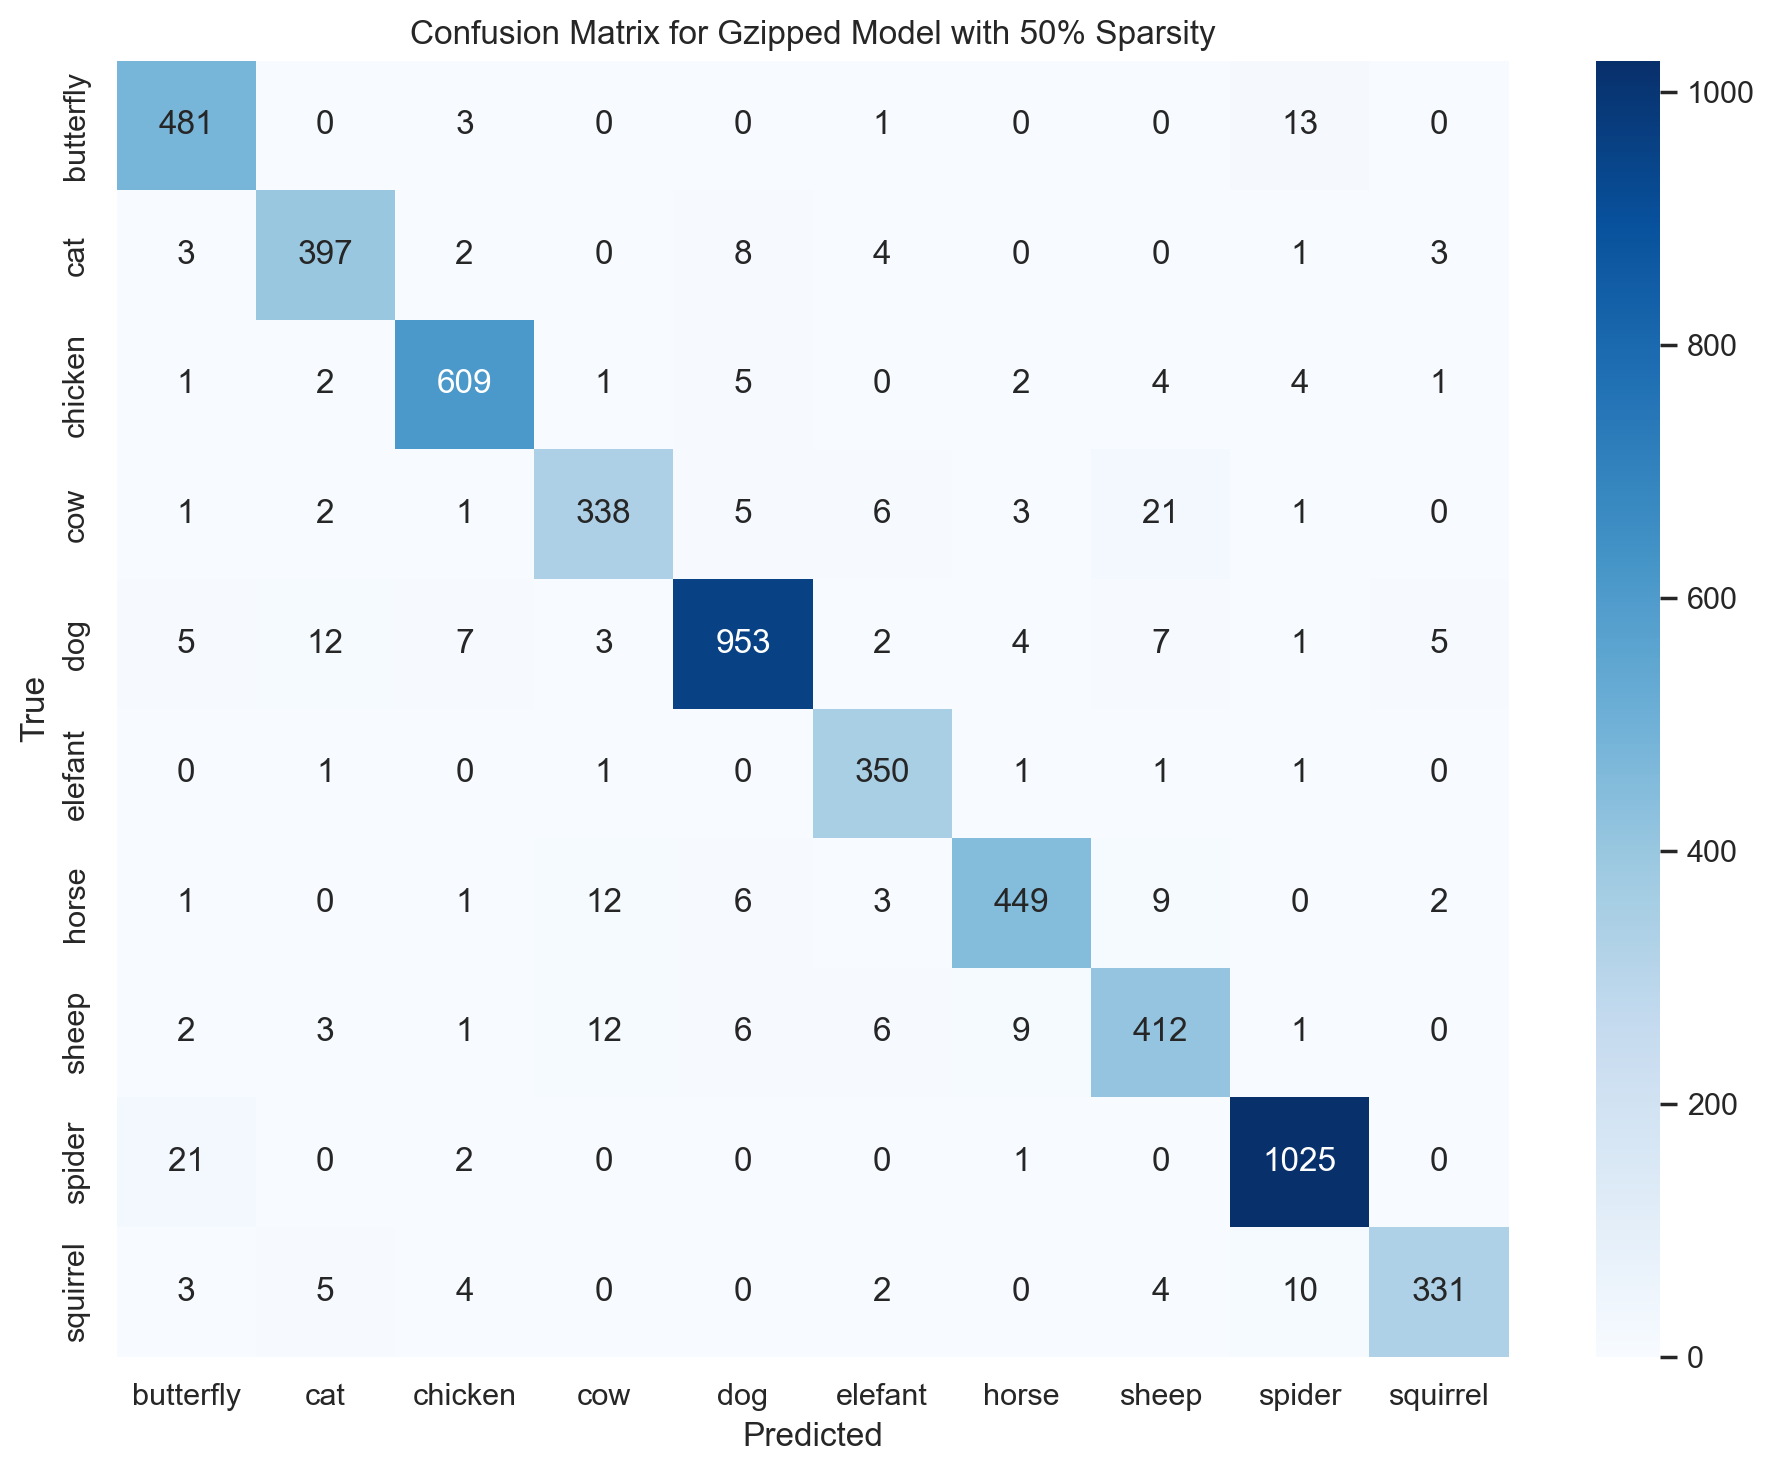

In [32]:
best_sparsity_percentage = 50  # Replace with your actual best sparsity level

# Get the compressed model filename
compressed_model_filename = get_compressed_model_filename(best_sparsity_percentage)

# Check if the compressed model file exists
if not os.path.exists(compressed_model_filename):
    raise FileNotFoundError(f"The compressed model file '{compressed_model_filename}' does not exist.")

# Load the compressed model
best_pruned_model = load_compressed_model(compressed_model_filename)

# Get class labels from the test_generator
class_labels = list(test_images.class_indices.keys())

# Evaluate the model on the test set
evaluate_model_on_test_set(best_pruned_model, test_images, class_labels)

### Since our computational resources are insufficient to support pruning the transferred model EfficientNet B7, we chose to use a custom CNN to demonstrate that pruning is still useful on this task.